## LandCoverNet Data Exploration

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.

In this notebook, a portion of the tutorial:

1. We will authenticate to MLHub via the API key to make requests on the LandCoverNet label collection

2. We will download the label collection into PC

3. We will perform some exploratory data analysis on these labels to get a better understanding of the LandCoverNet data


The [LandCoverNet Dataset on Radiant MLHub](tutorials/radiant-mlhub-landcovernet.ipynb) tutorial discusses setting up your authorization, listing collection properties, and retrieving the items (the data contained within them) from the collections of LandCoverNet dataset. Most requests to MLHub in this notebook will be based off this tutorial.

### Authentication

Access to the Radiant MLHub API requires an API key. To get your API key, go to [mlhub.earth](https://mlhub.earth/) and click the "Sign in / Register" button in the top right to log in. If you have not used Radiant MLHub before, you will need to sign up and create a new account; otherwise, just sign in. Once you have signed in, click on your user avatar in the top right and select the "Settings & API keys" from the dropdown menu.

In the **API Keys** section of this page, you will be able to create new API key(s). *Do not share* your API key with others as this may pose a security risk.

Next, we will create a `MLHUB_API_KEY` variable that `pystac-client` will use later use to add our API key to all requests:

In [14]:
import getpass

MLHUB_API_KEY = getpass.getpass(prompt="MLHub API Key: ")
MLHUB_ROOT_URL = "https://api.radiant.earth/mlhub/v1"

MLHub API Key:  ·································································


In [39]:
import os
import requests
import rioxarray
import tarfile
import shutil
import tempfile
from pathlib import Path
import itertools as it
from urllib.parse import urljoin

from pystac import Item
from pystac.extensions.eo import EOExtension
from pystac.extensions.label import LabelExtension, LabelRelType
from pystac.extensions.scientific import ScientificExtension
from pystac_client import Client

client = Client.open(
    MLHUB_ROOT_URL, parameters={"key": MLHUB_API_KEY}, ignore_conformance=True
)

In [16]:
class MLHubSession(requests.Session):
    def __init__(self, *args, api_key=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.params.update({"key": api_key})

    def request(self, method, url, *args, **kwargs):
        url_prefix = MLHUB_ROOT_URL.rstrip("/") + "/"
        url = urljoin(url_prefix, url)
        return super().request(method, url, *args, **kwargs)


session = MLHubSession(api_key=MLHUB_API_KEY)

### Listing Collection Properties

The following cell makes a request to the API for the metadata of the LandCoverNet labels collection and prints out a few important properties.

In [17]:
collection_id = "ref_landcovernet_v1_labels" #collections for the labels

collection = client.get_collection(collection_id)
collection_sci_ext = ScientificExtension.ext(collection)
print(f"Description: {collection.description}")
print(f"License: {collection.license}")
print(f"DOI: {collection_sci_ext.doi}")
print(f"Citation: {collection_sci_ext.citation}")

Description: LandCoverNet Labels
License: CC-BY-4.0
DOI: 10.34911/rdnt.d2ce8i
Citation: Alemohammad S.H., Ballantyne A., Bromberg Gaber Y., Booth K., Nakanuku-Diggs L., & Miglarese A.H. (2020) "LandCoverNet: A Global Land Cover Classification Training Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.d2ce8i


### Finding Possible Land Cover Labels

Each label item within the collection has a property which lists all of the possible land cover types and which ones are present in each label item. The code below prints out which land cover types are present in the dataset and we will reference these later in the notebook when we filter downloads.

In [5]:
item_search = client.search(collections=[collection_id])

first_item = next(item_search.get_items())
first_item_label_ext = LabelExtension.ext(first_item)

label_classes = first_item_label_ext.label_classes
for label_class in label_classes:
    print(f"Classes for {label_class.name}")
    for c in sorted(label_class.classes):
        print(f"- {c}")

Classes for labels
- (Semi) Natural Vegetation
- Artificial Bareground
- Cultivated Vegetation
- Natural Bareground
- No Data
- Permanent Snow/Ice
- Water
- Woody Vegetation


### Downloading Label Collections

We will download the label collections into a directory on PC.

In [7]:
!pwd

/home/jovyan/PlanetaryComputerExamples


In [18]:
tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
if not os.path.isdir(f"{tmp_dir}/landcovnet/labels"):
    os.makedirs(f"{tmp_dir}/landcovnet/labels") #create folder for labels to be stored

In [7]:
response = session.get(f"/archive/{collection_id}/info")
response.json()

{'collection': 'ref_landcovernet_v1_labels',
 'dataset': 'landcovernet_v1',
 'size': 19205520,
 'types': ['labels']}

In [37]:
archive_path = os.path.join(tmp_dir+"/landcovnet/labels", f"{collection_id}.tar.gz")
response = session.get(f"/archive/{collection_id}", allow_redirects=True)
with open(archive_path, "wb") as dst:
    dst.write(response.content)

In [ ]:
# open file
file = tarfile.open(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels.tar.gz")
# extract files
file.extractall(tmp_dir+"/landcovnet/labels/") #extract labels

In [11]:
import os
files = os.listdir(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels")
file_count = len(files) #we expect 1982 files
file_count

1982

### Exploration on Sample Label

Next, we will inspect a label item for its bands and visualise the label

In [19]:
file= tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_36MWT_15/labels.tif"
label_item = file
labels = rioxarray.open_rasterio(label_item).squeeze()

In [23]:
labels

<xarray.DataArray (band: 2, y: 256, x: 256)>
[131072 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 6.026e+05 6.026e+05 ... 6.052e+05 6.052e+05
  * y            (y) float64 9.239e+06 9.239e+06 ... 9.237e+06 9.237e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [28]:
labels=labels[0] #we want the first band of the label

In [29]:
labels

<xarray.DataArray (y: 256, x: 256)>
array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [7, 5, 5, ..., 5, 5, 7],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 7, 7, 7]], dtype=uint16)
Coordinates:
    band         int64 1
  * x            (x) float64 6.026e+05 6.026e+05 ... 6.052e+05 6.052e+05
  * y            (y) float64 9.239e+06 9.239e+06 ... 9.237e+06 9.237e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [34]:
classes=['No Data',
'Water',
'Artificial Bareground',
'Natural Bareground',
'Permanent Snow/Ice',
'Woody Vegetation',
'Cultivated Vegetation',
'(Semi) Natural Vegetation'
        ]

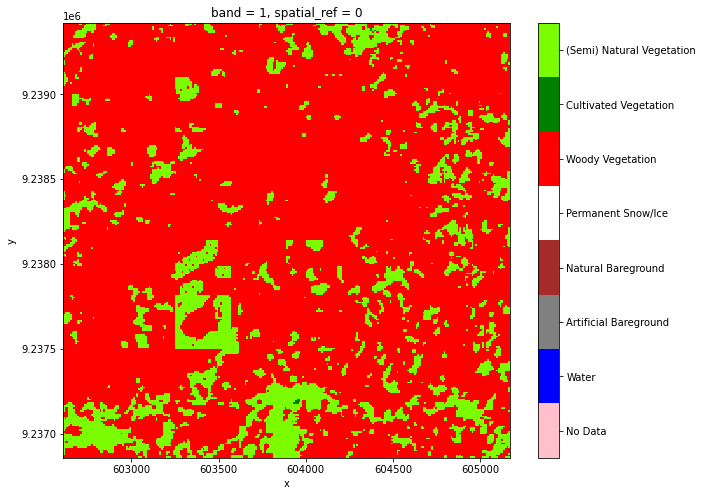

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10, 8))
cMap = ListedColormap(['pink','blue', 'grey', 'brown', 'white', 'red', 'green', 'lawngreen'])
p = labels.plot.imshow(
    ax=ax, cmap=cMap, add_colorbar=False, vmin=0, vmax=len(classes)
)
cbar = plt.colorbar(p)
cbar.set_ticks(np.arange(0.5, len(classes) + 0.5))
cbar.set_ticklabels(classes);

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import rioxarray
import planetary_computer
import stackstac
import rasterio.plot
import numpy as np
import dask

import contextlib
import warnings

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

In [4]:
training_catalog = pystac.read_file(
    tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/collection.json"
)

In [10]:
from dask.distributed import Client

client = Client()
client.run(lambda: warnings.filterwarnings("ignore", "Creating an ndarray from ragged"))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/daniel@radiant.earth/proxy/8787/status,
Dashboard: /user/daniel@radiant.earth/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44319,Workers: 4
Dashboard: /user/daniel@radiant.earth/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:44949,Total threads: 1
Dashboard: /user/daniel@radiant.earth/proxy/34141/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:34901,


In [5]:
links = training_catalog.get_item_links()

In [ ]:
N_SCENES = 100
links = training_catalog.get_item_links()[:N_SCENES]
label_items = [link.resolve_stac_object().target for link in links]

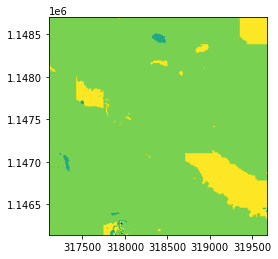

In [ ]:
label_item = next(training_catalog.get_all_items())
rasterio.plot.show(rasterio.open(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif"));

In [20]:
data = {
    "type": "FeatureCollection",
    "features": [],
}

In [26]:
import json
f = open(tmp_dir+'/json_data.json')

In [27]:
data = json.load(f)

In [ ]:
layer = GeoJSON(data=data)

In [39]:
bound={'coordinates': [[[-34.14308853658144, 17.984889483050374]]],
 'type': 'Polygon'}

In [ ]:
{"coordinates": [[[-34.143089, 18.902438],
                  [-34.135498,  18.913708],
                  [-30.762744, 18.324063,
                  [-30.761867, 18.325509]
                ]],
 "type": "Polygon"}

In [5]:
bound={"coordinates": [[[17.984889483050374, -34.13598336372205],
                  [24.01244998199735, -34.13598336372205],
                  [24.01244998199735, -30.757514929069913],
                  [17.984889483050374, -30.757514929069913],
                  [17.984889483050374, -34.13598336372205]]],
 "type": "Polygon"}

In [ ]:
-30.76 -34.14 18.90 18.32

In [14]:
label_item.geometry

{'coordinates': [[[37.32955714822882, 10.364020025810353],
   [37.3294343663916, 10.387163703120759],
   [37.35281134371039, 10.38728455271804],
   [37.35293240931304, 10.364140600401992],
   [37.32955714822882, 10.364020025810353]]],
 'type': 'Polygon'}

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
lat = [-34.143089, -34.135498, -30.762744, -30.761867]
lon = [18.902438, 18.913708, 18.324063, 18.325509]

gdf = gpd.GeoDataFrame()
gdf['lat'] = lat
gdf['lon'] = lon

dim = 1  # define the length of the side of the square
geoms = []
for index, row in gdf.iterrows():
    ln = row.lon
    lt = row.lat
    geom = Polygon([(ln, lt), ((ln + dim), lt), ((ln + dim), (lt - dim)), (ln, (lt - dim))])
    geoms.append(geom)

gdf['geometry'] = geoms 

In [4]:
import geoplot
geoplot.polyplot(gdf, figsize=(8, 4))

ModuleNotFoundError: No module named 'geoplot'

In [ ]:
gdf.plot("pop_est", cmap="Blues")  

In [10]:
from ipyleaflet import Map, GeoJSON

data = {
    "type": "FeatureCollection",
    "features": [],
}
data["features"].append(bound)


#center = shapely.geometry.shape(label_item.geometry).centroid.bounds[:2][::-1]

m = Map(center=(-34.14308853658144, 17.984889483050374), zoom=6.5)
layer = GeoJSON(data=data)

m.add_layer(layer)
m.layout.max_width = "600px"

m

Map(center=[-34.14308853658144, 17.984889483050374], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [30]:
def draw(self, mapbox_image, zoom, **kwargs) -> None:
  geometries = get_geometries(kwargs['geojson'])
  left_x = kwargs['left_x']
  top_y = kwargs['top_y']
  actual_x_padding = kwargs['actual_x_padding']
  actual_y_padding = kwargs['actual_y_padding']

  draw = ImageDraw.Draw(mapbox_image)
  for geometry in geometries:
    for coordinates in geometry['coordinates']:
        polygon = [(self.magnify(longitude_to_x(coordinate[0], zoom) - left_x, 100),
                    self.magnify(latitude_to_y(coordinate[1], zoom) - top_y, 100)) for coordinate in
                   coordinates]
        draw.polygon(polygon, fill=None, outline="blue")

def magnify(self, value, magnification):
 return value + (value * magnification) / 100

In [9]:
-34.14308853658144, -30.757514929069913, 17.984889483050374, 24.01244998199735

1

In [11]:
from ipyleaflet import Map, GeoJSON
m = Map(center=(4279839.99999999936,-3676160.0), zoom=1)

m.layout.max_width = "600px"

m

Map(center=[4279839.999999999, -3676160.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

In [14]:
# all the labels are from the same datetime
set([label_item.datetime for label_item in label_items])

{datetime.datetime(2018, 7, 1, 0, 0, tzinfo=tzlocal())}

In [15]:
bboxes = np.array([label_item.bbox for label_item in label_items])
mins = bboxes.min(0)
maxes = bboxes.max(0)
bbox = mins[0], mins[1], maxes[2], maxes[3]

In [35]:
print(find_match(label_item, image_item))

<Item id=ref_landcovernet_v1_source_31PGR_05_20180101>


In [42]:
def find_match(label_item, sentinel_items):
    # make sure we pick a sentinel scene that overlaps substantially with the label
    label_shape = shapely.geometry.shape(label_item.geometry)
    items2 = [
        item
        for item in sentinel_items
        if (
            shapely.geometry.shape(item.geometry).intersection(label_shape).area
            / label_shape.area
        )
        > 0.9
    ]
    
    for item in items2:
        if (pystac.extensions.eo.EOExtension.ext(item).cloud_cover)==None:
            sentinel_item=item
            return sentinel_item
    # sentinel_item = sorted(
    #     items2, key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover
    # )[0]
    # return sentinel_item

In [1]:
# items2 = [
#     item
#     for item in image_item
#     if (
#         shapely.geometry.shape(item.geometry).intersection(label_shape).area
#         / label_shape.area
#     )
#     > 0.9
# ]

In [2]:
# label_shape = shapely.geometry.shape(label_item.geometry)
# items2 = [
#     item
#     for item in image_item
#     if (
#         shapely.geometry.shape(item.geometry).intersection(label_shape).area
#         / label_shape.area
#     )
#     > 0.9
# ]

In [3]:
# itemize, haz=get_item(label_item, image_item, assets)

In [4]:
# len(itemize)

In [5]:
# hol= (itemize[1][0].values)

In [23]:
assets = ("B03", "B04", "B05")

In [37]:
print(find_match(label_item, image_item))

<Item id=ref_landcovernet_v1_source_37PCM_22_20180102>
[<Item id=ref_landcovernet_v1_source_37PCM_22_20180102>]


In [28]:
print(get_item(label_item, image_item, assets))

Attempting to find ref_landcovernet_v1_labels_37PCM_22 from within sentinel items
Bounds of the label item: 
(317110.0, 1146140.0, 319670.0, 1148700.0)
(<xarray.DataArray 'stackstac-b2d5fa78db540059a603973d90f33f20' (band: 3, y: 256, x: 256)>
array([[[0.2685 , 0.281  , 0.286  , ..., 0.2325 , 0.217  , 0.2285 ],
        [0.2745 , 0.2985 , 0.2615 , ..., 0.226  , 0.2355 , 0.23575],
        [0.2835 , 0.3065 , 0.244  , ..., 0.2225 , 0.231  , 0.2285 ],
        ...,
        [0.25175, 0.286  , 0.228  , ..., 0.3375 , 0.339  , 0.345  ],
        [0.268  , 0.279  , 0.22475, ..., 0.301  , 0.3225 , 0.3495 ],
        [0.218  , 0.22475, 0.21075, ..., 0.24425, 0.3075 , 0.3625 ]],

       [[0.4015 , 0.427  , 0.461  , ..., 0.3375 , 0.331  , 0.3475 ],
        [0.4285 , 0.441  , 0.4235 , ..., 0.332  , 0.3475 , 0.349  ],
        [0.452  , 0.4575 , 0.3965 , ..., 0.3175 , 0.3485 , 0.344  ],
        ...,
        [0.4105 , 0.4495 , 0.3765 , ..., 0.525  , 0.5385 , 0.532  ],
        [0.3995 , 0.452  , 0.3455 , ...

In [43]:
def get_item(label_item, sentinel_items, assets):
    assets = list(assets)
    labels = rioxarray.open_rasterio(
        tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif",
    ).squeeze()
    
    print(f"Attempting to find {label_item.id} from within sentinel items")
    sentinel_item = find_match(label_item, sentinel_items)
    bounds = tuple(round(x, 0) for x in labels.rio.bounds())
    print(f'Bounds of the label item: \n{bounds}')
    
    if not sentinel_item:
        print("No matching items found from find_match() method results")
    else:
        data = (
            stackstac.stack(
                planetary_computer.sign(sentinel_item).to_dict(),
                assets=assets,
                dtype="float32",
                resolution=10,
                bounds=bounds,
                epsg=labels.rio.crs.to_epsg(),
            )
            .squeeze()
            .compute(scheduler="single-threaded")
        )
        #assert data.shape[1:] == labels.shape
        data = data.assign_coords(x=labels.x.data, y=labels.y.data)
        data /= 4000
        data = np.clip(data, 0, 1)
        return data, labels.astype("int64")
    return None, labels.astype("int64")

In [19]:
source_imagery_links = label_item.get_links(rel=LabelRelType.SOURCE)
links_limit = 10
for item in source_imagery_links:
    item.target= f'http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/{item.target[-54:-10]}'
print(f"Source Imagery Links: {len(source_imagery_links)}")
for link in it.islice(source_imagery_links, links_limit):
    print(f"- {link.href}")
if len(source_imagery_links) > links_limit:
    print("...")

Source Imagery Links: 72
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180102
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180107
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180112
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180117
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180122
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180127
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180201
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcove

In [83]:
image_item.geometry

{'type': 'Polygon',
 'coordinates': [[[37.32955714822882, 10.364020025810353],
   [37.3294343663916, 10.387163703120759],
   [37.35281134371039, 10.38728455271804],
   [37.35293240931304, 10.364140600401992],
   [37.32955714822882, 10.364020025810353]]]}

In [20]:
image_item=[]

In [105]:
label_item

<Item id=ref_landcovernet_v1_labels_37PCM_22>

In [21]:
image_item=[]
image_link = source_imagery_links
for link in image_link:
    response = session.get(link.href)
    image_item.append(Item.from_dict(response.json()))
# print(f"Item ID: {image_item.id}")
# print("Assets:")
# for asset_key, asset in image_item.assets.items():
#     print(f"- Asset Key: {asset_key}")
#     asset_eo_ext = EOExtension.ext(asset)
#     if asset_eo_ext.bands is not None:
#         band_names = ", ".join(band.common_name for band in asset_eo_ext.bands)
#         print(f"  Bands:{band_names}")

In [88]:
# get_item_ = dask.delayed(get_item, nout=2)
# assets = ("B03", "B04", "B05")

# Xys = [get_item_(label_item, source_imagery_links, assets) for label_item in label_items]
# Xys = dask.persist(*Xys)

# Xys = dask.compute(*Xys)

In [38]:
label_item

<Item id=ref_landcovernet_v1_labels_31PGR_05>

In [41]:
len(Xys)

100

In [44]:
get_item_ = dask.delayed(get_item, nout=2)
assets = ("B03", "B04", "B05")

Xys = [get_item_(label_item, image_item, assets) for label_item in label_items]
Xys = dask.persist(*Xys)

Xys = dask.compute(*Xys)

Attempting to find ref_landcovernet_v1_labels_35PNR_13 from within sentinel items
Bounds of the label item: 
(593650.0, 1541220.0, 596210.0, 1543780.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_34MBC_28 from within sentinel items
Bounds of the label item: 
(258200.0, 9705470.0, 260760.0, 9708030.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_33KXV_06 from within sentinel items
Bounds of the label item: 
(600980.0, 7941280.0, 603540.0, 7943840.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_37NGE_27 from within sentinel items
Bounds of the label item: 
(751260.0, 395870.0, 753820.0, 398430.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_37PCM_22 from within sentinel items
Bounds of the label item: 
(317110.0, 1146140.0, 319670.0, 1148700.0)
Attempting to 

In [53]:
Xys[0][1][0]

<xarray.DataArray (y: 256, x: 256)>
array([[6, 6, 6, ..., 7, 7, 7],
       [6, 6, 6, ..., 7, 7, 7],
       [6, 6, 6, ..., 7, 7, 7],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.171e+05 3.171e+05 ... 3.197e+05 3.197e+05
  * y            (y) float64 1.149e+06 1.149e+06 ... 1.146e+06 1.146e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [39]:
len(Xys)

100